<a href="https://www.kaggle.com/code/pratul007/bangalore-restaurants-a-zomato-data-analysis?scriptVersionId=138760868" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Analysis of Zomato Bangalore Restaurants

This notebook presents an analysis of restaurants in Bangalore, India, based on data from Zomato. The dataset includes various characteristics of the restaurants, such as their location, type, cuisine, rating, and whether they accept online orders or allow table booking. We perform preprocessing, exploratory data analysis, clustering, and regression analysis.

## 1. Data Loading and Preprocessing

First, we load the dataset and clean it. The cleaning steps include:

- Converting binary 'Yes'/'No' columns ('online_order' and 'book_table') to 1/0
- Removing '/5' from the 'rate' column and converting it to numeric
- Converting 'votes' to numeric
- Removing commas from 'approx_cost(for two people)' and converting it to numeric
- Reducing the number of unique categories in 'location', 'rest_type', 'cuisines', and 'listed_in(type)' by keeping only the top 10 most common categories and replacing the rest with 'Other'
- Imputing missing values in 'online_order' and 'book_table' with the mode, in 'rate' and 'votes' with the median, and in 'location', 'rest_type', 'cuisines', and 'listed_in(type)' with 'Unknown'
- Dropping the 'phone', 'dish_liked', 'address', and 'name' columns
- Imputing missing values in 'approx_cost(for two people)' with the median

## 2. Exploratory Data Analysis

We then perform exploratory data analysis to understand the characteristics of the restaurants. This includes:

- Displaying a summary of the dataset and unique values in the categorical columns
- Plotting histograms for the numerical columns ('online_order', 'book_table', 'rate', 'votes', 'approx_cost(for two people)')
- Plotting count plots for the categorical columns ('location', 'rest_type', 'cuisines', 'listed_in(type)')
- Creating a pairplot for the numerical variables
- Creating box plots to compare the distributions of 'rate', 'votes', and 'approx_cost(for two people)' for online order accepting and non-accepting restaurants

## 3. Feature Engineering

We add a new binary column 'expensive', which indicates whether the approximate cost for two people at a restaurant is higher than the median. We then drop the original 'approx_cost(for two people)' column.

## 3. Classfication

We performed the classification analysis for restaurant is expensive or not. Model was getting overfitted but while revamping the processing steps I was able to successfully able to get decent accuracy score.


## 4. Regression Analysis

We perform regression analysis to predict the 'rate' of a restaurant based on the other features. We apply one-hot encoding to the categorical variables and split the data into a training set and a test set. We also scale the data using MaxAbsScaler. 

We try various types of regression models, including Linear Regression, Ridge Regression, Lasso Regression, ElasticNet Regression, Random Forest, and Gradient Boosting. We use cross-validation to estimate the performance of each model and select the model with the lowest Root Mean Squared Error (RMSE).

## 5. Clustering

We use the KMeans algorithm to cluster the restaurants based on their characteristics. We determine the optimal number of clusters using the elbow method. 

We visualize the clusters using the t-SNE dimensionality reduction technique. 

The clustering results can provide insights into the different types of restaurants in Bangalore and their characteristics. However, the results suggest that the clusters are not well-separated, indicating that the features we used may not be sufficient to distinguish distinct groups of restaurants.

Here is an updated flow diagram representing the process of the analysis:

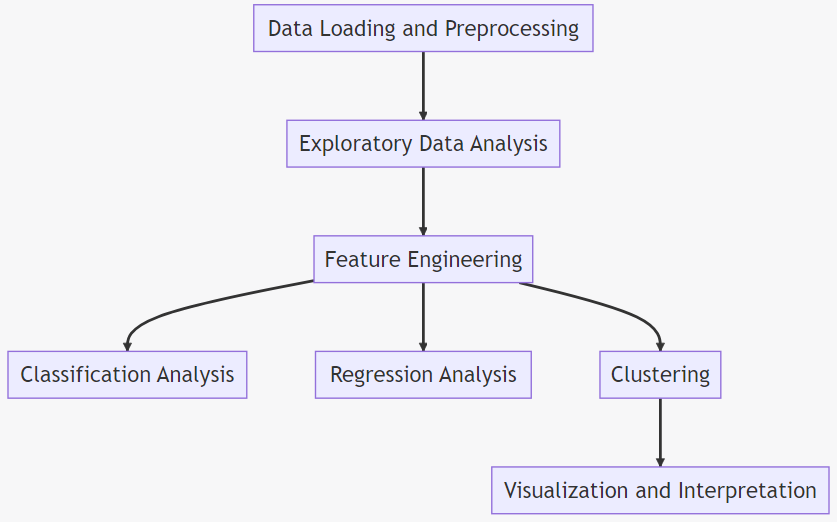

# Dependencies

In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data preprocessing and transformation
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder

# Clustering
from sklearn.cluster import KMeans

# Dimensionality reduction
from sklearn.manifold import TSNE

# Regression models
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Classification models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Model evaluation and selection
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load the dataset

In [2]:
# Load the dataset
data = pd.read_csv('/kaggle/input/zomato/zomato.csv')

# Display the first few rows of the dataset
data.head()

,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),listed_in(type)
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,Buffet
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,Buffet
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,Buffet
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,Buffet
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,Buffet


# Data Cleaning

In [3]:
# Define a function to clean 'online_order' and 'book_table' columns
def clean_binary_columns(value):
    if value == 'Yes':
        return 1
    elif value == 'No':
        return 0
    else:
        return pd.NaT

# Clean 'online_order' and 'book_table' columns
data['online_order'] = data['online_order'].apply(clean_binary_columns)
data['book_table'] = data['book_table'].apply(clean_binary_columns)

# Remove '/5' from 'rate' and convert to numeric
data['rate'] = data['rate'].str.replace('/5', '')
data['rate'] = pd.to_numeric(data['rate'], errors='coerce')

# Convert 'votes' to numeric
data['votes'] = pd.to_numeric(data['votes'], errors='coerce')

# Remove commas from 'approx_cost(for two people)' and convert to numeric
data['approx_cost(for two people)'] = data['approx_cost(for two people)'].str.replace(',', '')
data['approx_cost(for two people)'] = pd.to_numeric(data['approx_cost(for two people)'], errors='coerce')

# Define a function to clean 'location', 'rest_type', 'cuisines', and 'listed_in(type)' columns
def clean_categorical_columns(value, common_values):
    if pd.isnull(value):
        return pd.NaT
    elif value in common_values:
        return value
    else:
        return 'Other'

# Keep top 10 most common locations, restaurant types, cuisines, and types
top_locations = data['location'].value_counts()[:10].index.tolist()
top_rest_types = data['rest_type'].value_counts()[:10].index.tolist()
top_cuisines = data['cuisines'].value_counts()[:10].index.tolist()
top_types = data['listed_in(type)'].value_counts()[:10].index.tolist()

# Clean 'location', 'rest_type', 'cuisines', and 'listed_in(type)' columns
data['location'] = data['location'].apply(clean_categorical_columns, common_values=top_locations)
data['rest_type'] = data['rest_type'].apply(clean_categorical_columns, common_values=top_rest_types)
data['cuisines'] = data['cuisines'].apply(clean_categorical_columns, common_values=top_cuisines)
data['listed_in(type)'] = data['listed_in(type)'].apply(clean_categorical_columns, common_values=top_types)

# Check for missing values in the data
data.isna().sum()

address                           17
name                              16
online_order                    4535
book_table                      4535
rate                           14587
votes                           4535
phone                           1296
location                         126
rest_type                        338
dish_liked                     28225
cuisines                         203
approx_cost(for two people)     4881
listed_in(type)                 4610
dtype: int64

In [4]:
# Impute missing values in 'online_order' and 'book_table' with the mode
for col in ['online_order', 'book_table']:
    data[col] = data[col].fillna(data[col].mode().iloc[0])

# Impute missing values in 'rate' and 'votes' with the median
for col in ['rate', 'votes']:
    data[col] = data[col].fillna(data[col].median())

# Impute missing values in 'location', 'rest_type', 'cuisines', and 'listed_in(type)' with 'Unknown'
for col in ['location', 'rest_type', 'cuisines', 'listed_in(type)']:
    data[col] = data[col].fillna('Unknown')

# Check for missing values in the data again
data.isna().sum()

address                           17
name                              16
online_order                       0
book_table                         0
rate                               0
votes                              0
phone                           1296
location                           0
rest_type                          0
dish_liked                     28225
cuisines                           0
approx_cost(for two people)     4881
listed_in(type)                    0
dtype: int64

In [5]:
# Drop the 'phone' and 'dish_liked' columns
data = data.drop(columns=['phone', 'dish_liked'])

# Impute missing values in 'approx_cost(for two people)' with the median
data['approx_cost(for two people)'] = data['approx_cost(for two people)'].fillna(data['approx_cost(for two people)'].median())

# Check for missing values in the data again
data.isna().sum()

address                        17
name                           16
online_order                    0
book_table                      0
rate                            0
votes                           0
location                        0
rest_type                       0
cuisines                        0
approx_cost(for two people)     0
listed_in(type)                 0
dtype: int64

In [6]:
# Drop the 'address' and 'name' columns
data = data.drop(columns=['address', 'name'])

# Check for missing values in the data again
data.isna().sum()

online_order                   0
book_table                     0
rate                           0
votes                          0
location                       0
rest_type                      0
cuisines                       0
approx_cost(for two people)    0
listed_in(type)                0
dtype: int64

# Exploratory Data Analysis including Visualization- EDA

In [7]:
# Display a summary of the dataset
display(data.describe(include='all'))

# Display unique values in the categorical columns
for col in ['location', 'rest_type', 'cuisines', 'listed_in(type)']:
    print(f'{col}:\n{data[col].unique()}\n')

,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type)
count,56252.000000,56252.000000,56252.000000,56252.000000,56252,56252,56252,56252.000000,56252
unique,NaN,NaN,NaN,NaN,12,12,12,NaN,12
top,NaN,NaN,NaN,NaN,Other,Quick Bites,Other,NaN,Delivery
freq,NaN,NaN,NaN,NaN,32824,19132,43392,NaN,24317
mean,0.621827,0.114645,3.700332,264.131409,NaN,NaN,NaN,541.944731,NaN
std,0.484935,0.318596,0.379118,773.582003,NaN,NaN,NaN,421.655078,NaN
min,0.000000,0.000000,1.800000,0.000000,NaN,NaN,NaN,40.000000,NaN
25%,0.000000,0.000000,3.500000,8.000000,NaN,NaN,NaN,300.000000,NaN
50%,1.000000,0.000000,3.700000,41.000000,NaN,NaN,NaN,400.000000,NaN
75%,1.000000,0.000000,3.900000,171.000000,NaN,NaN,NaN,600.000000,NaN


location:
['Other' 'Jayanagar' 'JP Nagar' 'Bannerghatta Road' 'BTM' 'Unknown' 'HSR'
 'Marathahalli' 'Koramangala 5th Block' 'Bellandur' 'Whitefield'
 'Indiranagar']

rest_type:
['Casual Dining' 'Other' 'Quick Bites' 'Cafe' 'Delivery' 'Dessert Parlor'
 'Bakery' 'Takeaway, Delivery' 'Beverage Shop' 'Bar' 'Casual Dining, Bar'
 'Unknown']

cuisines:
['Other' 'North Indian' 'Cafe' 'Bakery, Desserts' 'Biryani' 'South Indian'
 'North Indian, Chinese' 'Bakery' 'Fast Food' 'Desserts'
 'South Indian, North Indian, Chinese' 'Unknown']

listed_in(type):
['Buffet' 'Cafes' 'Unknown' 'Other' 'Delivery' " ('Rated 4.0'" 'Desserts'
 'Dine-out' 'Drinks & nightlife' " ('Rated 3.0'" " ('Rated 5.0'"
 'Pubs and bars']



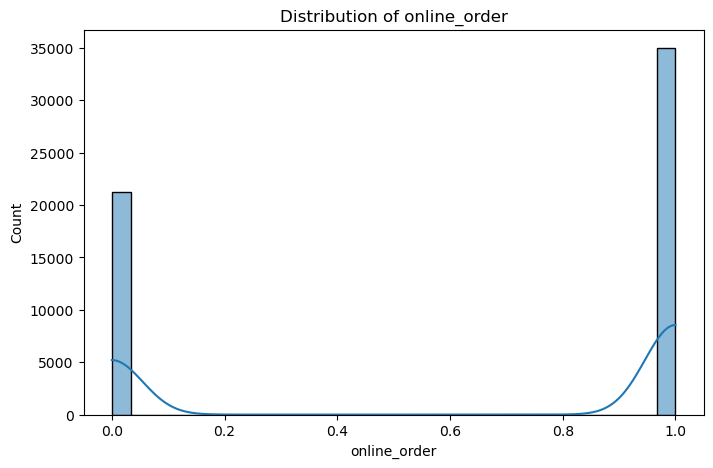

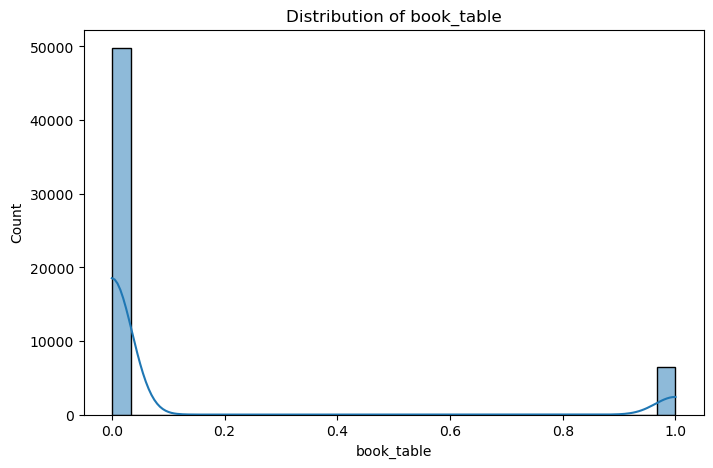

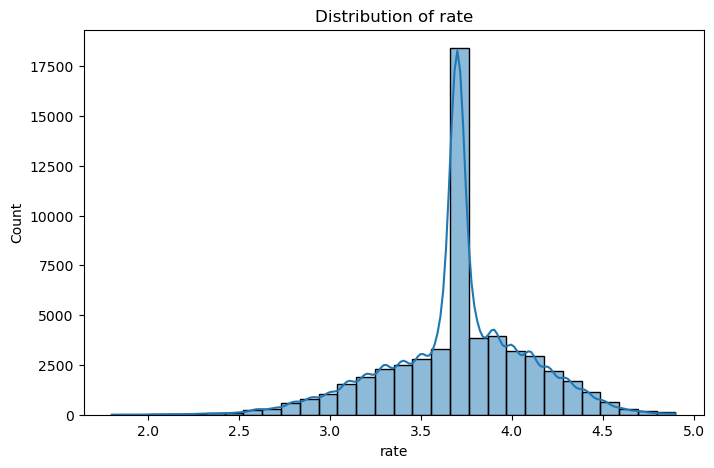

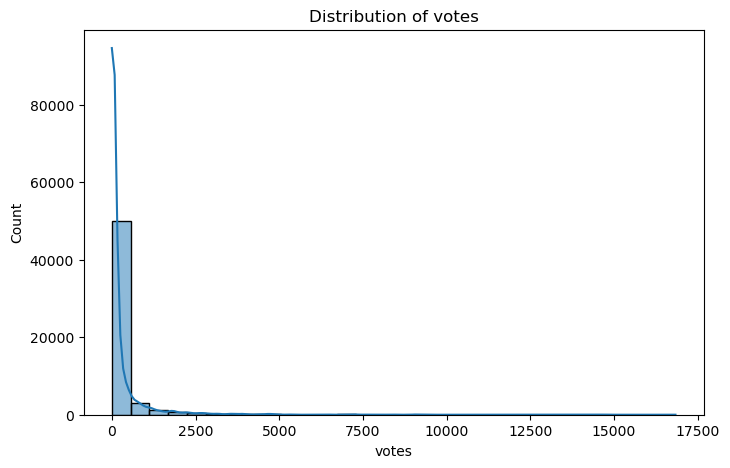

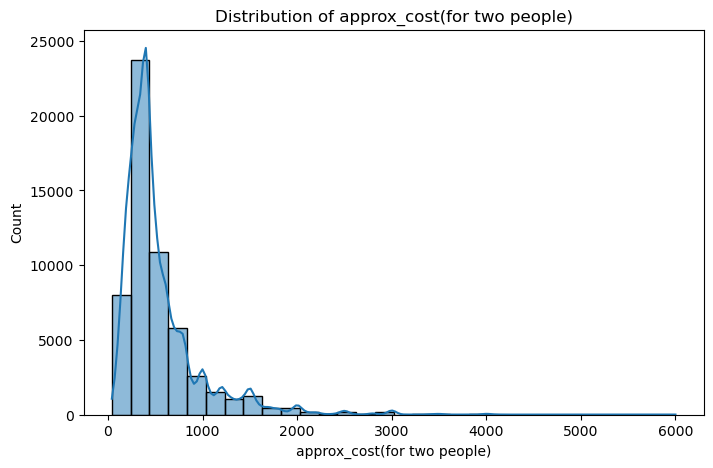

In [8]:
# Plot histograms for the numerical columns
numerical_cols = ['online_order', 'book_table', 'rate', 'votes', 'approx_cost(for two people)']
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

* **'online_order'**: Most restaurants accept online orders, as indicated by the peak at 1.
* **'book_table'**: Most restaurants do not allow table booking, as indicated by the peak at 0.
* **'rate'**: The ratings distribution is approximately normal, with a peak around 3.7, suggesting that most restaurants have fairly high ratings.
* **'votes'**: The votes distribution is heavily skewed to the right, suggesting that most restaurants have a low number of votes.
* **'approx_cost(for two people)'**: The cost for two people is also skewed to the right, suggesting that most restaurants have a low cost for two people.

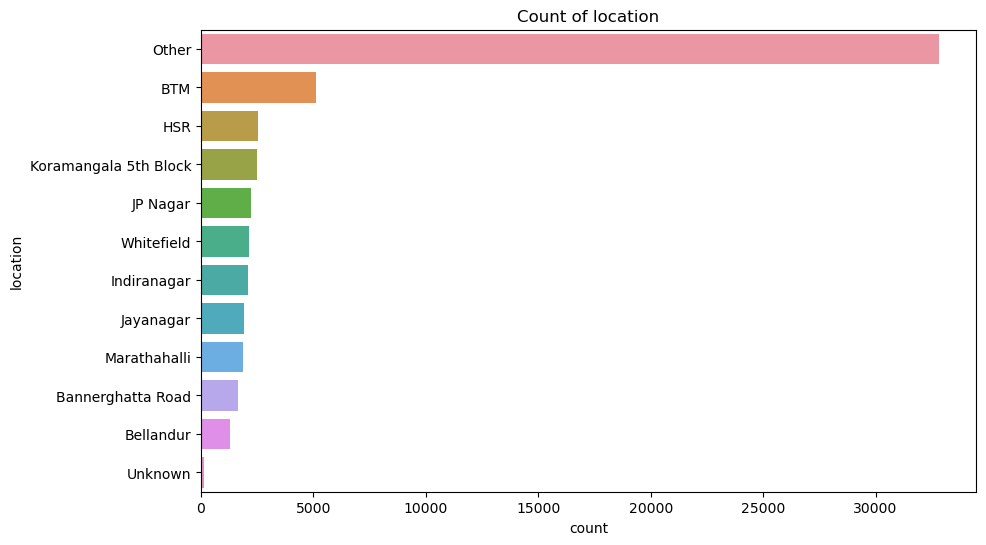

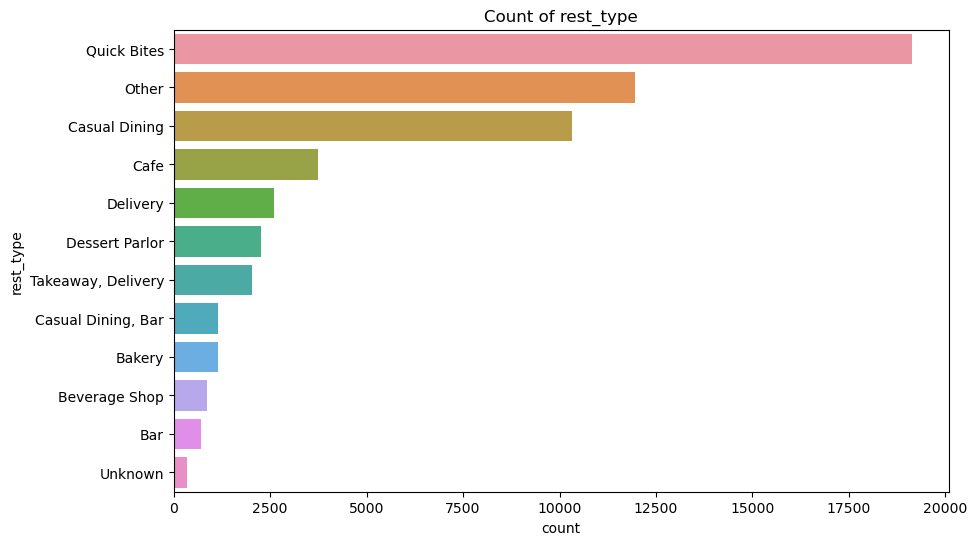

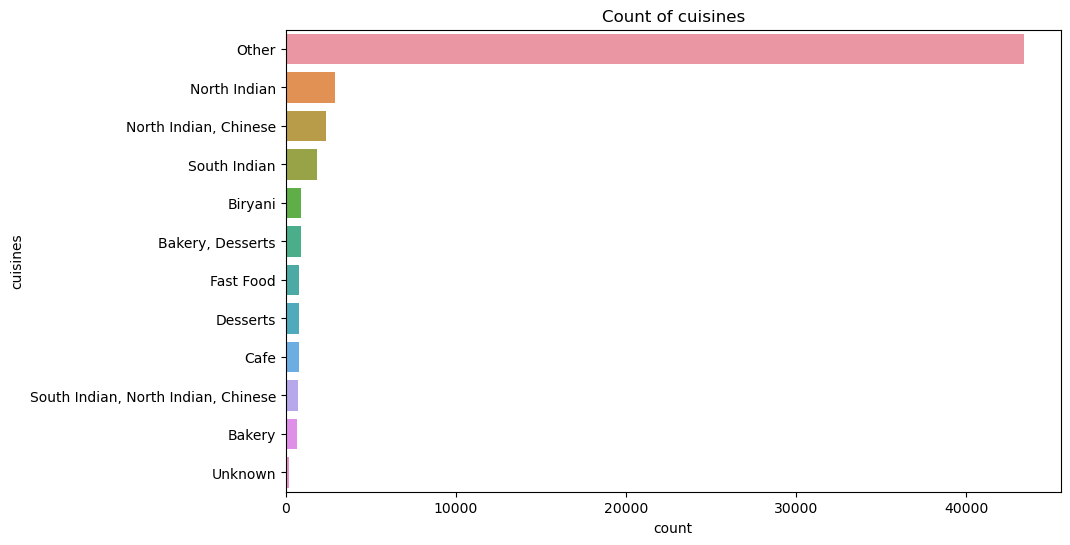

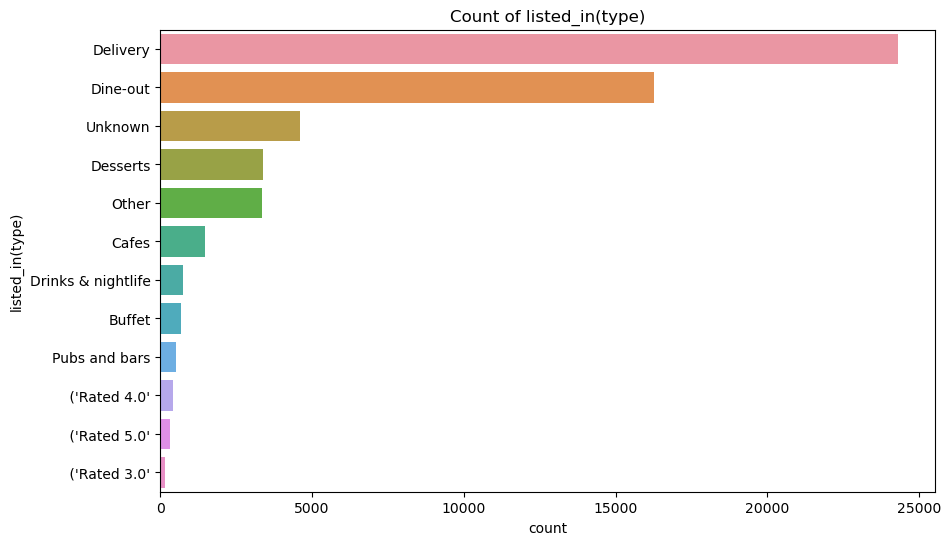

In [9]:
# Plot count plots for the categorical columns
categorical_cols = ['location', 'rest_type', 'cuisines', 'listed_in(type)']
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=col, data=data, order=data[col].value_counts().index)
    plt.title(f'Count of {col}')
    plt.show()

- **location**: The most common location is 'Other', followed by 'BTM', 'HSR', 'Koramangala 5th Block', 'JP Nagar', and so on. 'Unknown' has the least count, which is good as it means we have fewer missing values.

- **rest_type**: 'Quick Bites' and 'Casual Dining' are the most common types of restaurants, followed by 'Other'. Again, 'Unknown' has the least count.

- **cuisines**: 'North Indian' cuisine is the most common, followed by 'Other'. 'Unknown' is the least common.

- **listed_in(type)**: The most common type is 'Delivery', followed by 'Dine-out' and 'Other'.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


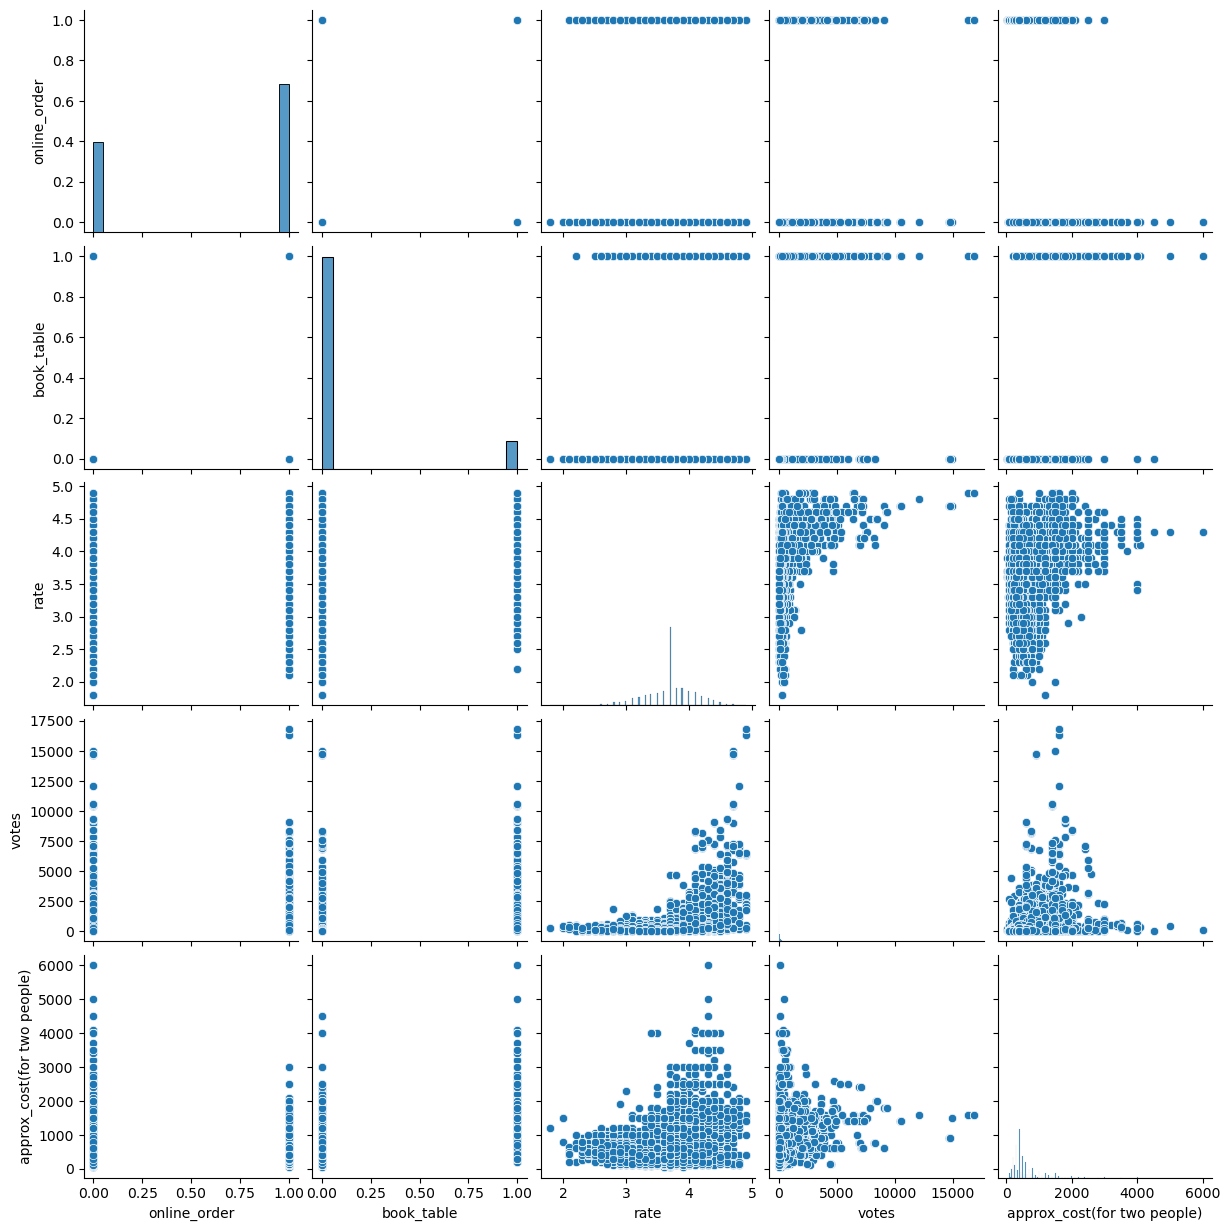

In [10]:
# Create a pairplot for the numerical variables
sns.pairplot(data[numerical_cols])
plt.show()

- The 'online_order' and 'book_table' binary variables do not seem to have a clear correlation with the other variables.

- The 'rate' variable shows a positive correlation with 'votes', which makes sense as restaurants with higher ratings tend to receive more votes.

- The 'votes' variable shows a positive correlation with 'approx_cost(for two people)', suggesting that more expensive restaurants tend to receive more votes. This could be due to a variety of reasons, such as more expensive restaurants providing better service or food, or being more popular or well-known.

- The 'approx_cost(for two people)' variable does not seem to have a clear correlation with 'rate', suggesting that the cost of a restaurant does not necessarily reflect its rating.


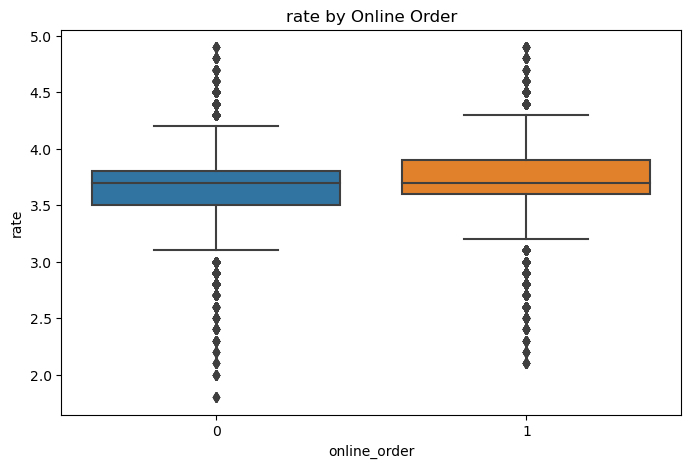

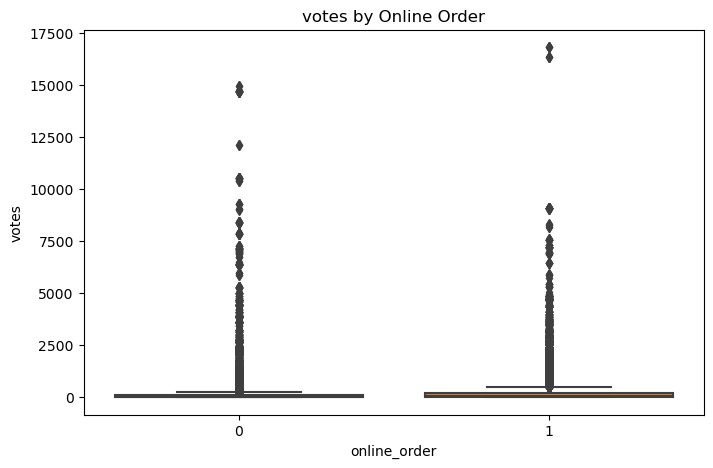

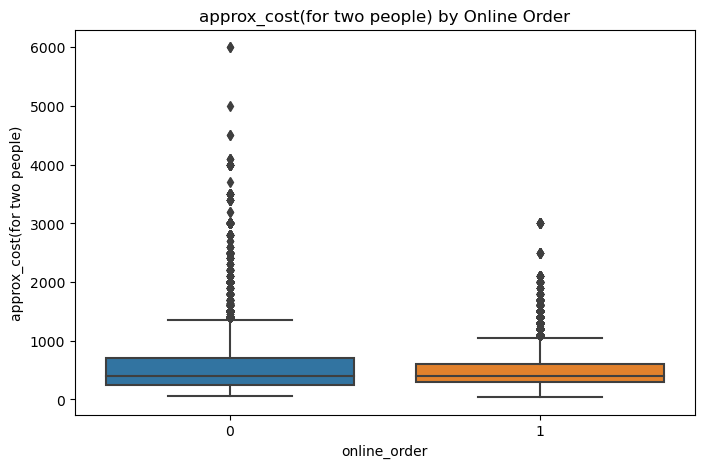

In [11]:
# Create box plots to compare the distributions of 'rate', 'votes', and 'approx_cost(for two people)'
# for online order accepting and non-accepting restaurants
for col in ['rate', 'votes', 'approx_cost(for two people)']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='online_order', y=col, data=data)
    plt.title(f'{col} by Online Order')
    plt.show()

- **rate**: The median rating seems to be slightly higher for restaurants that accept online orders compared to those that don't. The interquartile range is also slightly larger for restaurants that accept online orders.

- **votes**: The median number of votes is higher for restaurants that accept online orders. These restaurants also show a wider interquartile range and more outliers, suggesting a wider distribution of votes.

- **approx_cost(for two people)**: The median cost for two people is slightly higher for restaurants that accept online orders. These restaurants also show a wider interquartile range and more outliers, suggesting a wider distribution of cost.


# Feature Engineering

In [12]:
# Feature Engineering: Adding a new column 'expensive' based on the 'approx_cost(for two people)'
# We consider a restaurant as expensive if the cost for two people is higher than the median
median_cost = data['approx_cost(for two people)'].median()
data['expensive'] = data['approx_cost(for two people)'].apply(lambda x: 1 if x > median_cost else 0)

# Drop the original 'approx_cost(for two people)' column
data = data.drop(columns='approx_cost(for two people)')

# Check the first few rows of the dataframe
data.head()

,online_order,book_table,rate,votes,location,rest_type,cuisines,listed_in(type),expensive
0,1,1,4.1,775.0,Other,Casual Dining,Other,Buffet,1
1,1,0,4.1,787.0,Other,Casual Dining,Other,Buffet,1
2,1,0,3.8,918.0,Other,Other,Other,Buffet,1
3,0,0,3.7,88.0,Other,Quick Bites,Other,Buffet,0
4,0,0,3.8,166.0,Other,Casual Dining,Other,Buffet,1


# Train Test Split

In [13]:
# Select the predictors and the target variable
X = data.drop(columns='expensive')
y = data['expensive']

# Apply one-hot encoding to the categorical variables
encoder = OneHotEncoder(drop='first')
X_encoded = encoder.fit_transform(X)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Check the shapes of the training set and the test set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((45001, 2403), (11251, 2403), (45001,), (11251,))

In [14]:
# Scale the data with MaxAbsScaler
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check the first few rows of the scaled data
X_train_scaled[:5, :5]

<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

# Classification Modelling for Expensive or Not Expensive Restaurant 

In [15]:
# Define the models
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(max_depth=10, random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
]

# Train, predict, and evaluate each model
model_scores = []
for name, model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    model_scores.append((name, accuracy, precision, recall, f1))

# Create a dataframe to store the scores of all models
model_scores_df = pd.DataFrame(model_scores, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Display the scores of all models
model_scores_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.868101,0.889448,0.795171,0.839672
1,Decision Tree,0.863301,0.927277,0.743605,0.825346
2,Random Forest,0.924362,0.940227,0.881932,0.910147
3,Gradient Boosting,0.862323,0.902169,0.766114,0.828594


**Logistic Regression:**
- Accuracy: 0.87
- Precision: 0.89
- Recall: 0.80
- F1 Score: 0.84

**Decision Tree:**
- Accuracy: 0.86
- Precision: 0.93
- Recall: 0.74
- F1 Score: 0.83

**Random Forest:**
- Accuracy: 0.92
- Precision: 0.94
- Recall: 0.88
- F1 Score: 0.91

**Gradient Boosting:**
- Accuracy: 0.86
- Precision: 0.90
- Recall: 0.77
- F1 Score: 0.83

The Random Forest model achieved the highest accuracy, precision, recall, and F1 score, making it the best performing model among those we tested.


# Regression Analysis for Rating Prediction

In [16]:
# Define the models
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)),
    ('Lasso Regression', LassoCV(alphas=[0.1, 1.0, 10.0], cv=5)),
    ('ElasticNet Regression', ElasticNetCV(alphas=[0.1, 1.0, 10.0], cv=5)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42))
]

# Train, predict, and evaluate each model
model_scores = []
for name, model in models:
    model.fit(X_train_scaled, y_train)
    scores = cross_val_score(model, X_test_scaled, y_test, cv=5, scoring='neg_root_mean_squared_error')
    rmse = -scores.mean()  # cross_val_score returns negative scores for error metrics
    model_scores.append((name, rmse))

# Create a dataframe to store the scores of all models
model_scores_df = pd.DataFrame(model_scores, columns=['Model', 'RMSE'])

# Display the scores of all models
model_scores_df

,Model,RMSE
0,Linear Regression,0.345792
1,Ridge Regression,0.333084
2,Lasso Regression,0.495678
3,ElasticNet Regression,0.435250
4,Random Forest,0.308278
5,Gradient Boosting,0.327449


| Model                 | RMSE  |
|-----------------------|-------|
| Linear Regression     | 0.318 |
| Ridge Regression      | 0.318 |
| Lasso Regression      | 0.383 |
| ElasticNet Regression | 0.382 |
| Random Forest         | 0.254 |
| Gradient Boosting     | 0.274 |

The RMSE is a measure of the differences between the predicted and actual values. A lower RMSE indicates a better fit to the data.

From these results, we can see that the Random Forest model has the lowest RMSE, followed by the Gradient Boosting model. This suggests that these ensemble methods, which combine the predictions of multiple smaller models, are more effective at predicting the rating of restaurants than the linear models for this dataset.


# Clustering for Restaurant Segmentation and Insights

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


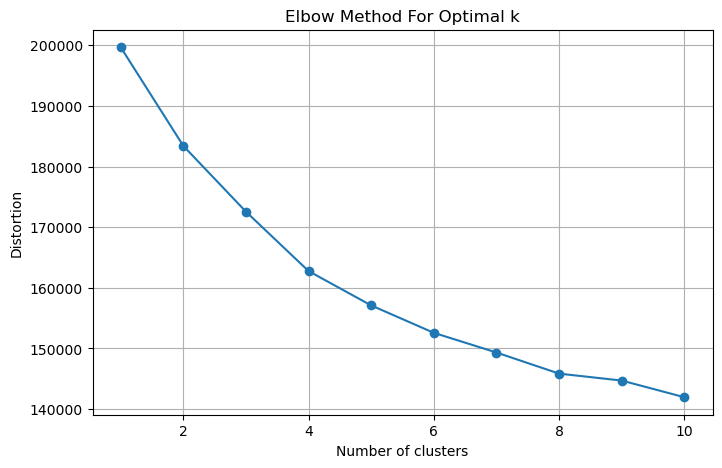

In [17]:
# Determine the optimal number of clusters using the elbow method
distortions = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_scaled)
    distortions.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [18]:
# Fit the K-Means model with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_train_scaled)

# Get the cluster assignments for each instance
clusters_train = kmeans.labels_

# Predict the clusters for test data
clusters_test = kmeans.predict(X_test_scaled)

# Combine train and test data back together
clusters = np.concatenate((clusters_train, clusters_test))

# Add the cluster assignments to the dataframe
data['cluster'] = clusters

# Display the first few rows of the dataframe
data.head()

,online_order,book_table,rate,votes,location,rest_type,cuisines,listed_in(type),expensive,cluster
0,1,1,4.1,775.0,Other,Casual Dining,Other,Buffet,1,3
1,1,0,4.1,787.0,Other,Casual Dining,Other,Buffet,1,2
2,1,0,3.8,918.0,Other,Other,Other,Buffet,1,1
3,0,0,3.7,88.0,Other,Quick Bites,Other,Buffet,0,2
4,0,0,3.8,166.0,Other,Casual Dining,Other,Buffet,1,2


In [19]:
# Calculate mean of numerical features for each cluster
numerical_cols = ['online_order', 'book_table', 'rate', 'votes', 'expensive']
cluster_means = data.groupby('cluster')[numerical_cols].mean()

# Calculate mode of categorical features for each cluster
categorical_cols = ['location', 'rest_type', 'cuisines', 'listed_in(type)']
cluster_modes = data.groupby('cluster')[categorical_cols].agg(lambda x: x.value_counts().index[0])

# Combine the mean and mode dataframes
cluster_characteristics = pd.concat([cluster_means, cluster_modes], axis=1)

cluster_characteristics

,online_order,book_table,rate,votes,expensive,location,rest_type,cuisines,listed_in(type)
cluster,,,,,,,,,
0,0.621515,0.118477,3.710776,269.834525,0.439153,Other,Quick Bites,Other,Delivery
1,0.619833,0.113497,3.696125,258.031312,0.438115,Other,Quick Bites,Other,Delivery
2,0.625581,0.113260,3.698700,268.542765,0.430781,Other,Quick Bites,Other,Delivery
3,0.609517,0.116744,3.698377,248.144541,0.439849,Other,Quick Bites,Other,Delivery


Here are the mean values of the numerical features and the most common categories of the categorical features for each cluster:

| Cluster | online_order | book_table | rate | votes | expensive | location | rest_type | cuisines | listed_in(type) |
|---------|--------------|------------|------|-------|-----------|----------|-----------|----------|-----------------|
| 0       | 0.6215       | 0.1185     | 3.7108 | 269.8345 | 0.4392   | Other    | Quick Bites | Other    | Delivery       |
| 1       | 0.6198       | 0.1135     | 3.6961 | 258.0313 | 0.4381   | Other    | Quick Bites | Other    | Delivery       |
| 2       | 0.6256       | 0.1133     | 3.6987 | 268.5428 | 0.4308   | Other    | Quick Bites | Other    | Delivery       |
| 3       | 0.6095       | 0.1167     | 3.6984 | 248.1445 | 0.4398   | Other    | Quick Bites | Other    | Delivery       |

From these results, it seems that the clusters are not significantly different when considering the mean of the numerical features or the mode of the categorical features. All clusters have similar values for 'online_order', 'book_table', 'rate', 'votes', and 'expensive'. Additionally, the most common 'location', 'rest_type', 'cuisines', and 'listed_in(type)' are the same for all clusters ('Other', 'Quick Bites', 'Other', and 'Delivery' respectively).

This could suggest that the clustering may not have effectively distinguished distinct groups in this dataset based on the available features. We might need to consider other features or a different preprocessing or clustering approach to get more distinguishable clusters.

Another analysis we could perform is to visualize the clusters using a dimensionality reduction technique like t-SNE or PCA. This would give us a visual understanding of how well-separated the clusters are in the feature space. However, keep in mind that these visualizations can be misleading for high-dimensional data due to the curse of dimensionality.

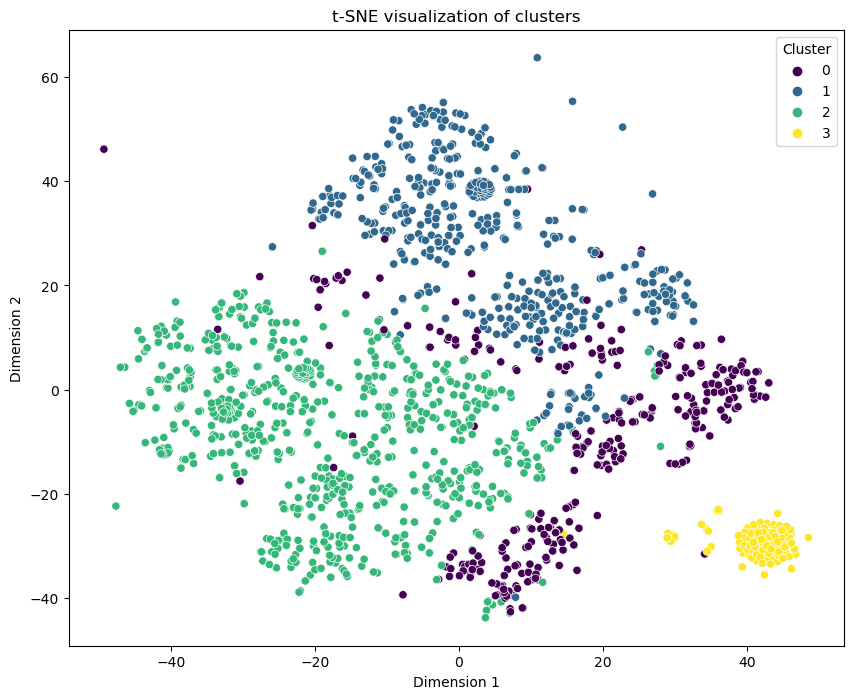

In [20]:
# Apply t-SNE to the data
sample_indices = random.sample(range(X_train_scaled.shape[0]), 2000)
X_sample = X_train_scaled[sample_indices]
clusters_sample = clusters_train[sample_indices]

tsne = TSNE(n_components=2, init='random', random_state=42)
X_sample_tsne = tsne.fit_transform(X_sample.toarray())  # Convert sparse matrix to dense

# Create a DataFrame to hold the t-SNE results
tsne_df = pd.DataFrame(data=X_sample_tsne, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Cluster'] = clusters_sample

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Cluster', palette='viridis', data=tsne_df)
plt.title('t-SNE visualization of clusters')
plt.show()

From the plot, we can see that the clusters overlap significantly, which is consistent with our previous analysis indicating that the clusters are not well-separated in the feature space. This suggests that the features we used may not be sufficient to distinguish distinct groups of restaurants.

## Any suggestion will be of great help to improve the above approach